bi + ml --> final

In [1]:
import sys
sys.path.append('../../../')

In [2]:
import pandas as pd
import numpy as np
import streamlit as st
import plotly.express as px
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import FunctionTransformer

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
st.set_option('deprecation.showPyplotGlobalUse', False)

# Functions

In [ ]:
def log_transform(x):
    return np.log(x + 1)

def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters,multiclass):
    """
    
    """
    
    ##
    transformer = FunctionTransformer(log_transform)
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", transformer)]) #MinMaxScaler()
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = GradientBoostingClassifier(random_state=0,n_iter_no_change=25,warm_start=True,max_features=1.0)
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),('model', pipe_model)])
    
    ##
    # ('model', CalibratedClassifierCV(base_estimator=pipe_model,method='isotonic'))])
    ##
    if multiclass == 'no':
        model_grid = GridSearchCV(model,parameters,cv=4,scoring='recall',verbose=0,return_train_score=True).fit(X_train,y_train)
    else:
        model_grid = GridSearchCV(model,parameters,cv=4,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    st.markdown('##### GridSearchCV results...')
    st.write("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    st.write("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    st.write("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [ ]:
def model_calibration(model,X_test,y_test):
    """
    
    """
    st.markdown("##### Calibrating the model...")
    best_model = model.best_estimator_
    calibrator = CalibratedClassifierCV(best_model, cv='prefit')
    calibrator = calibrator.fit(X_test,y_test)
    return calibrator

In [ ]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    st.markdown('##### Test results...')
    y_test_predict_grid = model.predict(X_test)    
    st.write("Model Test Recall:", metrics.recall_score(y_test, y_test_predict_grid))
    st.write('--------------------------------------------------')
    st.write('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='true') 
    col1, col2 = st.columns([1, 2])
    ConfusionMatrixDisplay(cm,display_labels=['No','Yes']).plot()
    col1.pyplot()
    col2.text('Model Report:\n ' + classification_report(y_test, y_test_predict_grid))

    st.markdown("##### Features importance: ")
    feature_importances = model.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    val = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
#             st.write('{}: {}'.format(name, score))
            lista.append(name)
            val.append(score)
    ris = pd.DataFrame({'feature': lista, 'score':val})
    st.plotly_chart(px.bar(ris,x='feature',y='score'))
    return model

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("datalake/train_eng.pkl")
val = pd.read_pickle("datalake/val_eng.pkl")

In [4]:
cols = ['card1', 'card2', 'card3','card5','M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38','num_transaction_per_time']

In [5]:
df = df.drop(columns=cols)

In [6]:
val = val.drop(columns=cols)

# 2.0 Machine Learning
## 2.1 Training model

In [7]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [8]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [ ]:
max_depth_model = 3
max_n_est = 200

In [10]:
parameters = {'model__max_depth':[2,max_depth_model],'model__n_estimators':[100,max_n_est],'model__learning_rate':[0.1],'model__min_samples_leaf':[3]}

In [12]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters,'no')

GridSearchCV results...
Mean Train Scores: 
[0.87915758 0.89078492 0.8819401  0.90386593 0.92404796 0.92849121
 0.91881546 0.92288487 0.9127528  0.9127528  0.90262    0.90262
 0.94310833 0.94310833 0.92666503 0.92666503]

Mean CV Scores: 
[0.8275819  0.83032306 0.82558813 0.83480718 0.8340601  0.83480755
 0.83405985 0.8338106  0.83505655 0.83505655 0.83244046 0.83244046
 0.84128581 0.84128581 0.83667489 0.83667489]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



## 2.2 Evaluation model

In [13]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [14]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [15]:
m = model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8517179023508138
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     19976
         1.0       0.32      0.85      0.47      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.85      0.69     21635
weighted avg       0.93      0.85      0.88     21635

ProductCD: 0.3204076362998419
TransactionAmt: 0.14343000107184956
card4: 0.13104672782140595
P_emaildomain: 0.025223769402368465
addr2: 0.012033488338027181
multi_transaction_per_time: 0.006267940261555033
R_emaildomain: 0.0051341140250081435
device_info_v4: 0.00510613494903186
DeviceType: 0.003658257210281853
max_d: 0.002309863815483917
max_c: 0.0014520695771733966
card6: 0.0010054128432358431
addr1: 3.549110105942713e-05
browser_enc: 2.5990696714438614e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   FunctionTransformer(func=<function log_transform at 0x7feb1b8d4430>))]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d',...
                                 

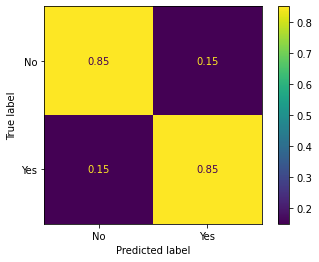

In [16]:
model_evaluation(m.base_estimator, X_val, y_val)

# 6.0 Model Output

In [27]:
# with open('datalake/trained_model_v1.pkl','wb') as file:
#     pickle.dump(m.base_estimator, file)